<a href="https://colab.research.google.com/github/AliARajabi/deep-learning/blob/main/RNN/Music_Generator_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from music21 import converter, instrument, note, chord, stream, midi
import glob
import time
import numpy as np
import keras.utils as utils
import pandas as pd
import regex as re
import matplotlib.pyplot as plt

In [18]:
def load_training_data():
    with open('/content/test.abc', "r") as f:
        text = f.read()
    songs = extract_song_snippet(text)
    return songs

def extract_song_snippet(text):
    pattern = '(^|\n\n)(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song[1] for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

In [21]:
songs = load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [23]:
# Melody-RNN Format is a sequence of 8-bit integers indicating the following:
# MELODY_NOTE_ON = [0, 127] # (note on at that MIDI pitch)
MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# Each element in the sequence lasts for one sixteenth note.
# This can encode monophonic music only.

def streamToNoteArray(stream):
    """
    Convert a Music21 sequence to a numpy array of int8s into Melody-RNN format:
        0-127 - note on at specified pitch
        128   - note off
        129   - no event
    """
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25)) # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), np.round(element.quarterLength / 0.25), element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    df = pd.DataFrame({'pos': np_stream_list.T[0], 'dur': np_stream_list.T[1], 'pitch': np_stream_list.T[2]})
    df = df.sort_values(['pos','pitch'], ascending=[True, False]) # sort the dataframe properly
    df = df.drop_duplicates(subset=['pos']) # drop duplicate values
    # part 2, convert into a sequence of note events
    output = np.zeros(total_length+1, dtype=np.int16) + np.int16(MELODY_NO_EVENT)  # set array full of no events by default.
    # Fill in the output list
    for i in range(total_length):
        if not df[df.pos==i].empty:
            n = df[df.pos==i].iloc[0] # pick the highest pitch at each semiquaver
            output[i] = n.pitch # set note on
            output[i+n.dur] = MELODY_NOTE_OFF
    return output

def noteArrayToDataFrame(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a dataframe.
    """
    df = pd.DataFrame({"code": note_array})
    df['offset'] = df.index
    df['duration'] = df.index
    df = df[df.code != MELODY_NO_EVENT]
    df.duration = df.duration.diff(-1) * -1 * 0.25  # calculate durations and change to quarter note fractions
    df = df.fillna(0.25)
    return df[['code','duration']]


def noteArrayToStream(note_array):
    """
    Convert a numpy array containing a Melody-RNN sequence into a music21 stream.
    """
    df = noteArrayToDataFrame(note_array)
    melody_stream = stream.Stream()
    for index, row in df.iterrows():
        if row.code == MELODY_NO_EVENT:
            new_note = note.Rest() # bit of an oversimplification, doesn't produce long notes.
        elif row.code == MELODY_NOTE_OFF:
            new_note = note.Rest()
        else:
            new_note = note.Note(row.code)
        new_note.quarterLength = row.duration
        melody_stream.append(new_note)
    return melody_stream



In [24]:
!git clone https://github.com/AliARajabi/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 221 (delta 11), reused 1 (delta 1), pack-reused 195
Receiving objects: 100% (221/221), 30.94 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [28]:
wm_mid = converter.parse("/content/deep-learning/RNN/music generator/original_metheny.mid")


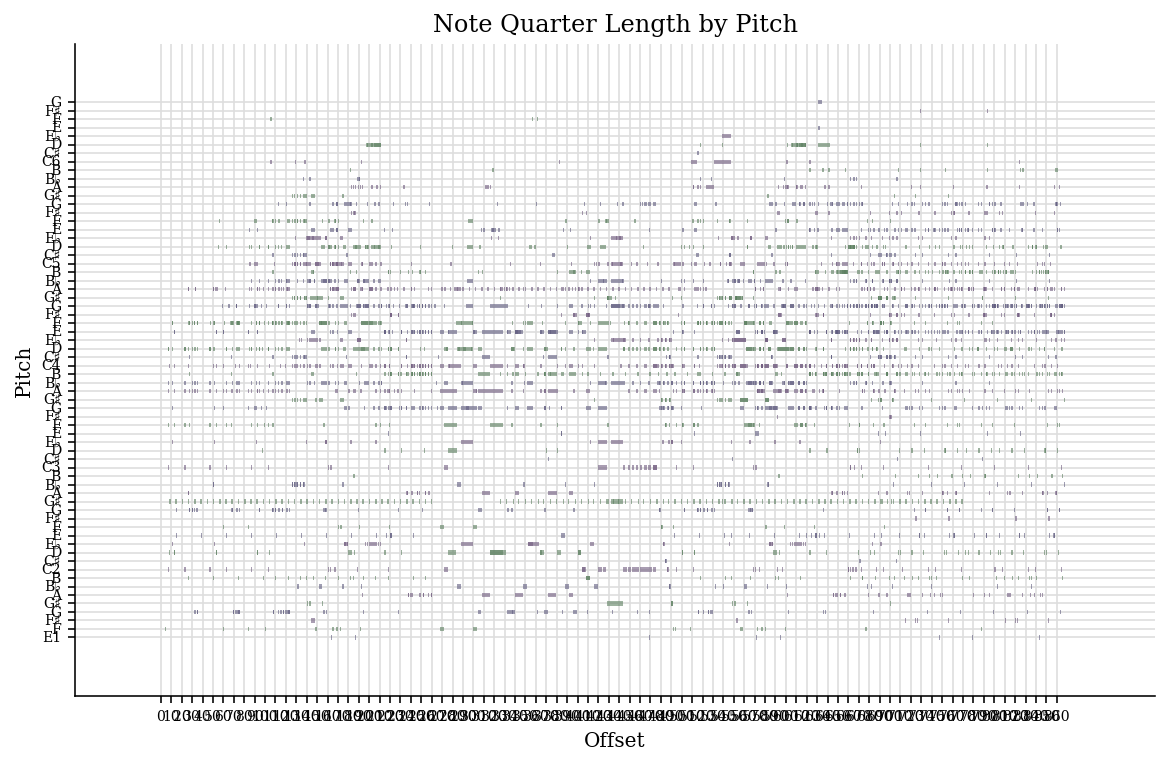

In [31]:

wm_mid.plot('pianoroll')

In [34]:
wm_mel_rnn = streamToNoteArray(wm_mid)
print(len(wm_mel_rnn))

3473


In [35]:
training_dataset = np.array(wm_mel_rnn)
np.savez('melody_training_dataset.npz', train=training_dataset)

In [123]:
print(training_dataset.shape)
print(type(training_dataset))

(3473,)
<class 'numpy.ndarray'>


In [37]:
assert isinstance(training_dataset, np.ndarray), "returned result should be a numpy array"

In [45]:
def get_batches(vectorized_songs, seq_length, batch_size):
  n=training_dataset.shape[0]
  idx = np.random.choice(n-seq_length, batch_size)
  x_data=[vectorized_songs[i:i+seq_length] for i in idx]
  y_data=[vectorized_songs[i+1:i+seq_length+1] for i in idx]
  x_batch = np.reshape(x_data, [batch_size, seq_length])
  y_batch = np.reshape(y_data, [batch_size, seq_length])
  return x_batch, y_batch

In [48]:
x_batch, y_batch = get_batches(training_dataset, 10, 2)
print(x_batch)
print(y_batch)

[[128 128 128 128 128 128 128 128 128 128]
 [128 128 128 128  74 128  75  77 128 128]]
[[128 128 128 128 128 128 128 128 128 128]
 [128 128 128  74 128  75  77 128 128  77]]


In [50]:
from tensorflow.keras.layers import Embedding , LSTM ,Dense , Input 
from tensorflow.keras import Model

In [78]:
vocab=sorted(set(training_dataset))
print(len(vocab))
print(vocab)

39
[46, 52, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 128, 129]


In [85]:
vocab=[voca/129 for voca in vocab]

In [86]:
print(len(vocab))
print(vocab)

39
[0.35658914728682173, 0.40310077519379844, 0.4263565891472868, 0.43410852713178294, 0.4418604651162791, 0.4496124031007752, 0.46511627906976744, 0.4728682170542636, 0.4806201550387597, 0.4883720930232558, 0.49612403100775193, 0.5038759689922481, 0.5116279069767442, 0.5193798449612403, 0.5271317829457365, 0.5348837209302325, 0.5426356589147286, 0.5503875968992248, 0.5581395348837209, 0.5658914728682171, 0.5736434108527132, 0.5813953488372093, 0.5891472868217055, 0.5968992248062015, 0.6046511627906976, 0.6124031007751938, 0.6201550387596899, 0.627906976744186, 0.6356589147286822, 0.6434108527131783, 0.6511627906976745, 0.6589147286821705, 0.6666666666666666, 0.6744186046511628, 0.689922480620155, 0.6976744186046512, 0.7054263565891473, 0.9922480620155039, 1.0]


In [95]:
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

In [ ]:
print(char2idx['129'])

In [96]:
print('{')
for char,_ in zip(char2idx, range(len(vocab)+1)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  0.35658914728682173:   0,
  0.40310077519379844:   1,
  0.4263565891472868:   2,
  0.43410852713178294:   3,
  0.4418604651162791:   4,
  0.4496124031007752:   5,
  0.46511627906976744:   6,
  0.4728682170542636:   7,
  0.4806201550387597:   8,
  0.4883720930232558:   9,
  0.49612403100775193:  10,
  0.5038759689922481:  11,
  0.5116279069767442:  12,
  0.5193798449612403:  13,
  0.5271317829457365:  14,
  0.5348837209302325:  15,
  0.5426356589147286:  16,
  0.5503875968992248:  17,
  0.5581395348837209:  18,
  0.5658914728682171:  19,
  0.5736434108527132:  20,
  0.5813953488372093:  21,
  0.5891472868217055:  22,
  0.5968992248062015:  23,
  0.6046511627906976:  24,
  0.6124031007751938:  25,
  0.6201550387596899:  26,
  0.627906976744186:  27,
  0.6356589147286822:  28,
  0.6434108527131783:  29,
  0.6511627906976745:  30,
  0.6589147286821705:  31,
  0.6666666666666666:  32,
  0.6744186046511628:  33,
  0.689922480620155:  34,
  0.6976744186046512:  35,
  0.7054263565891473:  

In [97]:
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char/129] for char in string])
  return vectorized_output

# def vectorize_string(string):
  # TODO

training_dataset = vectorize_string(training_dataset)

In [82]:
import tensorflow as tf

def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Layer 1: Embedding layer to transform indices into dense vectors 
    #   of a fixed embedding size
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Layer 2: LSTM with `rnn_units` number of units. 
    # TODO: Call the LSTM function defined above to add this layer.
    LSTM(rnn_units), 
    # LSTM('''TODO'''),

    # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size. 
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(vocab_size)
    # '''TODO: DENSE LAYER HERE'''
  ])

  return model

# Build a simple model with default hyperparameters. You will get the 
#   chance to change these later.
model = build_model(len(vocab), embedding_dim=1, rnn_units=1024, batch_size=32)


In [98]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (32, None, 1)             39        
_________________________________________________________________
lstm_5 (LSTM)                (32, None, 1024)          4202496   
_________________________________________________________________
dense_5 (Dense)              (32, None, 39)            39975     
Total params: 4,242,510
Trainable params: 4,242,510
Non-trainable params: 0
_________________________________________________________________


In [99]:
x, y = get_batches(training_dataset, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 39) # (batch_size, sequence_length, vocab_size)


In [101]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss


In [103]:
import os
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experiment between 1 and 64
seq_length = 100  # Experiment between 50 and 500
learning_rate = 5e-3  # Experiment between 1e-5 and 1e-1

# Model parameters: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experiment between 1 and 2048

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [108]:

import time
from tqdm import tqdm

from IPython import display as ipythondisplay
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

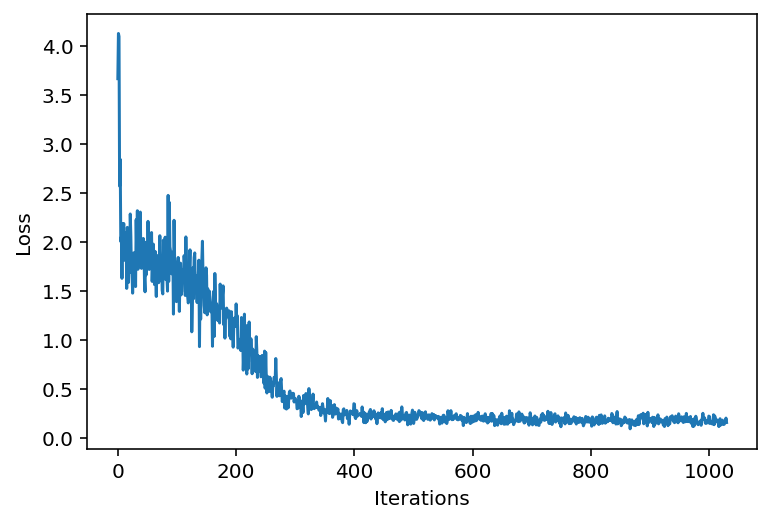

 52%|█████▏    | 1030/2000 [1:02:01<57:58,  3.59s/it]

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f0315d6c290> (for post_execute):


KeyboardInterrupt: ignored

In [111]:
### Define optimizer and training operation ###

'''TODO: instantiate a new model for training using the `build_model`
  function and the hyperparameters created above.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

'''TODO: instantiate an optimizer with its learning rate.
  Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: feed the current input into the model and generate predictions'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''TODO: compute the loss!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Now, compute the gradients 
  '''TODO: complete the function call for gradient computation. 
      Remember that we want the gradient of the loss with respect all 
      of the model parameters. 
      HINT: use `model.trainable_variables` to get a list of all model
      parameters.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Begin training!#
##################

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batches(training_dataset, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Update the progress bar
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Save the trained model and the weights
model.save_weights(checkpoint_prefix)

In [122]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (1, None, 256)            9984      
_________________________________________________________________
lstm_13 (LSTM)               (1, None, 1024)           5246976   
_________________________________________________________________
dense_13 (Dense)             (1, None, 39)             39975     
Total params: 5,296,935
Trainable params: 5,296,935
Non-trainable params: 0
_________________________________________________________________


In [ ]:

  0.5426356589147286:  16,
  0.5503875968992248:  17,
  0.5581395348837209:  18,
  0.5658914728682171:  19,
  0.5736434108527132:  20,
  0.5813953488372093:  21,
  0.5891472868217055:  22,
  0.5968992248062015:  23,
  0.6046511627906976:  24,
  0.6124031007751938:  25,

In [136]:
def generate_music(model, start_, generation_length=1000):
  input_eval = [char2idx[s] for s in start_]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id]) 
    
  return (np.concatenate((start_, text_generated), axis=None))

In [137]:
generated_text = generate_music(model, start_=np.array([0.40310077519379844,0.5426356589147286,0.5813953488372093]), generation_length=1000)

100%|██████████| 1000/1000 [00:08<00:00, 119.38it/s]


In [139]:
print(generated_text[:10])

[0.40310078 0.54263566 0.58139535 0.53488372 0.55813953 0.50387597
 0.53488372 0.55813953 0.99224806 0.57364341]


In [144]:
print(len(vocab))
print(vocab)

39
[0.35658914728682173, 0.40310077519379844, 0.4263565891472868, 0.43410852713178294, 0.4418604651162791, 0.4496124031007752, 0.46511627906976744, 0.4728682170542636, 0.4806201550387597, 0.4883720930232558, 0.49612403100775193, 0.5038759689922481, 0.5116279069767442, 0.5193798449612403, 0.5271317829457365, 0.5348837209302325, 0.5426356589147286, 0.5503875968992248, 0.5581395348837209, 0.5658914728682171, 0.5736434108527132, 0.5813953488372093, 0.5891472868217055, 0.5968992248062015, 0.6046511627906976, 0.6124031007751938, 0.6201550387596899, 0.627906976744186, 0.6356589147286822, 0.6434108527131783, 0.6511627906976745, 0.6589147286821705, 0.6666666666666666, 0.6744186046511628, 0.689922480620155, 0.6976744186046512, 0.7054263565891473, 0.9922480620155039, 1.0]


In [142]:
idx2char = {i:u for i, u in enumerate(vocab)}

In [148]:
generated_music=generated_text*129

In [149]:
print(generated_music[:10])

[ 52.  70.  75.  69.  72.  65.  69.  72. 128.  74.]


In [150]:
melody_stream = noteArrayToStream(generated_music) # turn into a music21 stream

In [151]:
print(type(melody_stream))

<class 'music21.stream.Stream'>


In [153]:
from music21 import converter, instrument, note, chord, stream, midi

In [154]:
sp = midi.realtime.StreamPlayer(melody_stream)
sp.play()

StreamPlayerException: ignored

In [157]:
!pip install pygame

     |████████████████████████████████| 11.8MB 17.4MB/s 


In [174]:
fp = melody_stream.write('midi')
print(len(melody_stream))


1002


In [184]:
import os
import socket
import threading
import IPython
import portpicker

from six.moves import SimpleHTTPServer
from six.moves import socketserver

from google.colab import output

class _V6Server(socketserver.TCPServer):
  address_family = socket.AF_INET6


class _FileHandler(SimpleHTTPServer.SimpleHTTPRequestHandler):
  """SimpleHTTPRequestHandler with a couple tweaks."""

  def translate_path(self, path):
    # Client specifies absolute paths.
    return path

  def log_message(self, fmt, *args):
    # Suppress logging since it's on the background. Any errors will be reported
    # via the handler.
    pass

  def end_headers(self):
    # Do not cache the response in the notebook, since it may be quite large.
    self.send_header('x-colab-notebook-cache-control', 'no-cache')
    SimpleHTTPServer.SimpleHTTPRequestHandler.end_headers(self)


def play_audio(filename):
  """Downloads the file to the user's local disk via a browser download action.

  Args:
    filename: Name of the file on disk to be downloaded.
  """

  started = threading.Event()
  port = portpicker.pick_unused_port()

  def server_entry():
    httpd = _V6Server(('::', port), _FileHandler)
    started.set()
    # Serve multiple requests, in case the audio is played more than once.
    httpd.serve_forever()

  thread = threading.Thread(target=server_entry)
  thread.start()
  started.wait()
  
  output.eval_js("""
    (()=> {
      const audio = document.createElement('audio');
      audio.controls = true;
      audio.autoplay = true;
      audio.src = `https://localhost:%(port)d%(path)s`;
      document.body.appendChild(audio);
    })()
  """% {'port': port, 'path': os.path.abspath(filename)})
print('playing')
play_audio('test.mid')

playing


In [181]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!fluidsynth -ni font.sf2 test.mid -F output.wav -r 44100
from IPython.display import Audio
Audio('output.wav')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Parameter 'test.mid' not a SoundFont or MIDI file or error occurred identifying it.
No midi file specified!


ValueError: ignored

In [189]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
!pip install midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio

FluidSynth("font.sf2").midi_to_audio('test.midi', 'test.wav')
Audio("test.wav")


Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


ValueError: ignored